# ___Stacking & Blending - Supervised Machine Learning___

## ___Stacking___

_Stacked Generalization or “Stacking” for short is an ensemble machine learning algorithm._

_It involves combining the predictions from multiple machine learning models on the same dataset, like bagging and boosting._

_The architecture of a stacking model involves two or more base models, often referred to as level-0 models, and a meta-model that combines the predictions of the base models, referred to as a level-1 model._

* ___Level-0 Models (Base-Models)___ _: Models fit on the training data and whose predictions are compiled._
* ___Level-1 Model (Meta-Model)___ _: Model that learns how to best combine the predictions of the base models._

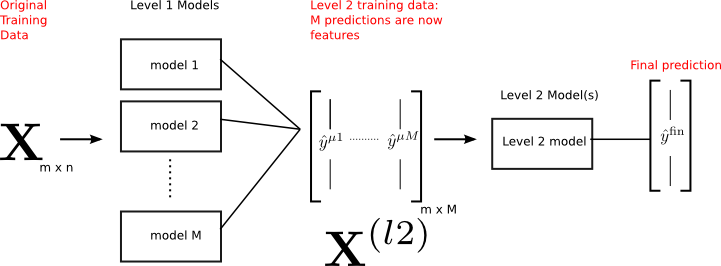

_Stacking uses a similar idea to k-folds cross validation to create out-of-sample predictions._

_The key word here is __out-of-sample__, since if we were to use predictions from the M models that are fit to all the training data, then the second level model will be biased towards the best of M models. This will be of no use._

_As an illustration of this point, let’s say that model 1 has lower training accuracy, than model 2 on the training data. There may however be data points where model 1 performs better, but for some reason it performs terribly on others (see figure below). Instead, model 2 may have a better overall performance on all the data points, but it has worse performance on the very set of points where model 1 is better. The idea is to combine these two models where they perform the best. This is why creating out-of-sample predictions have a higher chance of capturing distinct regions where each model performs the best._

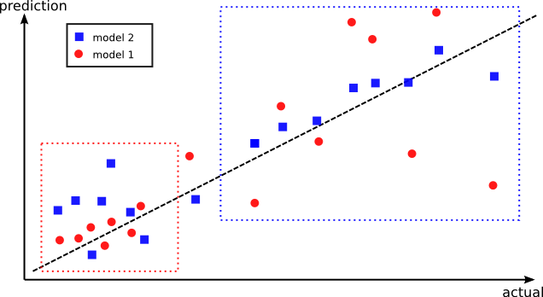

_First, let me describe what I mean by stacking. The idea is to divide the training set into several pieces like you would do in k-folds cross validation. For each fold, the rest of the folds are used to obtain a predictions using all the models 1…M. The best way to explain this is by the figure below:_

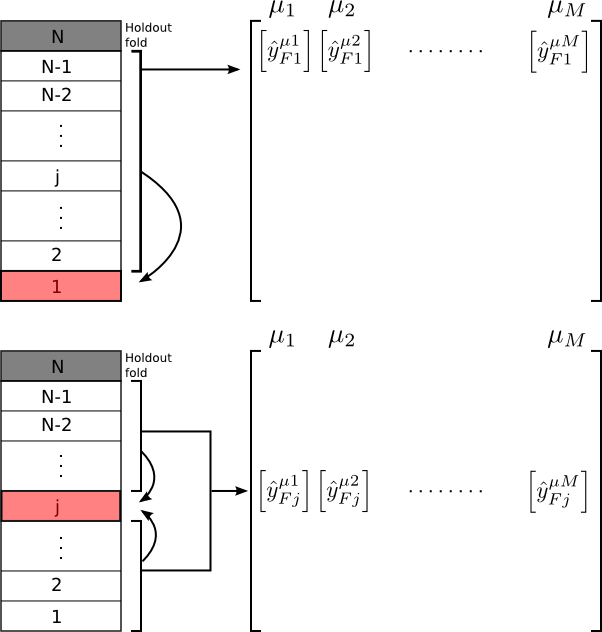

_Here, we divide our training data into N folds, and hold the Nth fold out for validation (i.e. the holdout fold). Suppose we have M number of models (we will later use M=3). As the figure shows, prediction for each fold (Fj) is obtained from a fit using the rest of the folds and collected in an out-of-sample predictions matrix (Xoos). Namely, the level 2 training data Xl2 is Xoos. This is repeated for each of the models. The out-of -sample prediction matrix (Xoos) will then be used in a second level training (by some method of choice) to obtain the final predictions for all the data points. There are several points to note:_

* _We have not simply stacked the predictions on all the training data from the M models column-by-column to create a second level training data, due to the problem mentioned above (the fact that the second level training will simply choose the best of the M models)._

* _By using out-of-sample predictions, we still have a large data to train the second level model. We just need to train on Xoos and predict on the holdout fold (Nth). This is in contrast to model ensembles._

_Now, each model (1...M) can be trained on the (N-1) folds and a prediction on the holdout fold (Nth) can be made. There is nothing new here. But what we do is that, using the second level model which is trained on Xoos, we will obtain predictions on the holdout data. We want that the predictions from the second level training be better than each of the M predictions from the original models. If not, we will have to restructure the way we combine models._

## ___Blending___

_Blending is a similar approach to stacking._

* _The train set is split into training and validation sets._
* _We train the base models on the training set._
* _We make predictions only on the validation set and the test set._
* _The validation predictions are used as features to build a new model._
* _This model is used to make final predictions on the test set using the prediction values as features._

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [2]:
df = pd.read_csv(r"C:\Users\PiyushSin\Desktop\datasets\sonar.all-data.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [3]:
X = df.iloc[:,:-1]
print(X.shape)

(208, 60)


In [4]:
y=df.iloc[:,-1]

In [5]:
le = preprocessing.LabelEncoder()
le.fit(["R","M"])

LabelEncoder()

In [6]:
list(le.classes_)

['M', 'R']

In [7]:
y=le.transform(y)

In [8]:
#Lets split our data in train and test 
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1)

## ___Stacking Classification Model - Manual___

In [9]:
def Stacking(model,train,y,test,n_fold):
    
    folds=StratifiedKFold(n_splits=n_fold,random_state=1)
    
    test_pred=np.empty((0,1),float)
    train_pred=np.empty((0,1),float)
    
    for train_indices,val_indices in folds.split(train,y):
        x_train,x_val=train.iloc[train_indices,:],train.iloc[val_indices,:]
        y_train,y_val=y[train_indices],y[val_indices]
        model.fit(X=x_train,y=y_train)
        train_pred=np.append(train_pred,model.predict(x_val))
    
    test_pred=model.predict(test)
    return test_pred.reshape(-1,1),train_pred

In [10]:
# Base Model 1
model1 = DecisionTreeClassifier(random_state=1)

test_pred1 ,train_pred1=Stacking(model=model1,n_fold=10, train=X_train,test=X_test,y=y_train)

train_pred1=pd.DataFrame(train_pred1)
test_pred1=pd.DataFrame(test_pred1)

In [11]:
# Base Model 2
model2 = KNeighborsClassifier()

test_pred2 ,train_pred2=Stacking(model=model2,n_fold=10,train=X_train,test=X_test,y=y_train)

train_pred2=pd.DataFrame(train_pred2)
test_pred2=pd.DataFrame(test_pred2)

In [12]:
validation_prediction = pd.concat([train_pred1, train_pred2], axis=1)
test_prediction = pd.concat([test_pred1, test_pred2], axis=1)

# Meta Model
model = LogisticRegression(random_state=1)
model.fit(validation_prediction,y_train)
model.score(test_prediction, y_test)

0.7692307692307693

## ___Blending Classification Model - Manual___

In [13]:
#Lets split our data in train and validation 
X_training,X_valid,y_training,y_valid=train_test_split(X_train,y_train,test_size=0.3,random_state=1)

In [14]:
model1 = DecisionTreeClassifier(random_state=1)
model2 = KNeighborsClassifier()

model1.fit(X_training,y_training)
model2.fit(X_training,y_training)

KNeighborsClassifier()

In [15]:
valid_pred1=model1.predict(X_valid)
valid_pred2=model2.predict(X_valid)

In [16]:
test_pred1=model1.predict(X_test)
test_pred2=model2.predict(X_test)

In [17]:
blending_predictions=np.column_stack((valid_pred1,valid_pred2))
blending_test_predictions=np.column_stack((test_pred1,test_pred2))

In [18]:
# Meta Model
model = LogisticRegression(random_state=1)
model.fit(blending_predictions,y_valid)

LogisticRegression(random_state=1)

In [19]:
test_predictions=model.predict(blending_test_predictions)

In [20]:
model.score(test_prediction, y_test)

0.7692307692307693

## ___Model using sklearn___

In [21]:
from sklearn.ensemble import StackingClassifier

In [22]:
model = StackingClassifier(estimators=[('rf',DecisionTreeClassifier(random_state=1)),('knn',KNeighborsClassifier())], 
                       final_estimator=LogisticRegression(random_state=1),cv = 5,stack_method='auto',n_jobs=-1)

In [23]:
model.fit(X_train,y_train)

StackingClassifier(cv=5,
                   estimators=[('rf', DecisionTreeClassifier(random_state=1)),
                               ('knn', KNeighborsClassifier())],
                   final_estimator=LogisticRegression(random_state=1),
                   n_jobs=-1)

In [24]:
pred = model.predict(X_test)
pred

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0])

In [25]:
y_test

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0])

## ___Boston Housing - Regression Model___

In [26]:
from sklearn.datasets import load_boston

def dataset_to_df(load):
    # Load the input data into the dataframe
    df = pd.DataFrame(load.data, columns=load.feature_names)
    
    # Add the output data into the dataframe
    df['label'] = pd.Series(load.target)
    
    # Return the dataframe
    return df

df = dataset_to_df(load_boston())

In [27]:
from sklearn.model_selection import train_test_split

# Getting the output variable
y = df['label']

# Getting the input variables
X = df.drop(['label'], axis=1)

# Diving our input and output into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, 
                                    test_size=0.33, 
                                    random_state=42
                                   )

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       scoring_test=r2_score, do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    best_model = fitted_model.best_estimator_
    
    if do_probabilities:
          pred = fitted_model.predict_proba(X_test_data)
    else:
          pred = fitted_model.predict(X_test_data)
    
    score = scoring_test(y_test_data, pred)
    
    return [best_model, pred, score]

In [29]:
### LGBM & XGB to be discussed in next file

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Defining our estimator, the algorithm to optimize
models_to_train = [XGBRegressor(), LGBMRegressor(), RandomForestRegressor()]

# Defining the hyperparameters to optimize
grid_parameters = [
    { # XGBoost
        'n_estimators': [400, 700],
        'colsample_bytree': [0.7],
        'max_depth': [15],
        'reg_alpha': [1.1, 1.2],
        'reg_lambda': [1.1, 1.2],
        'subsample': [0.7]
    },
    { # LightGBM
        'n_estimators': [400, 700],
        'learning_rate': [0.12],
        'colsample_bytree': [0.7],
        'max_depth': [4],
        'num_leaves': [10],
        'reg_alpha': [1.1, 1.2],
        'reg_lambda': [1.1, 1.2],
        'min_split_gain': [0.3],
        'subsample': [0.8],
        'subsample_freq': [10]
    }, 
    { # Random Forest
        'max_depth':[3, 5], 
        'n_estimators':[100, 200],
        'max_features':[2, 4]
    }
]

In [30]:
models_preds_scores = []

for i, model in enumerate(models_to_train):
    params = grid_parameters[i]
    
    result = algorithm_pipeline(X_train, X_test, y_train, y_test, 
                                 model, params, cv=2)
    models_preds_scores.append(result)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    4.5s finished


[23:28:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.5s finished


Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    3.5s finished


In [31]:
for result in models_preds_scores:
    print('Model: {0}, Score: {1}'.format(type(result[0]).__name__, result[2]))

Model: XGBRegressor, Score: 0.8747010245205682
Model: LGBMRegressor, Score: 0.8591268041294562
Model: RandomForestRegressor, Score: 0.8311383048519205


In [36]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

estimators = [('ridge', Ridge()),
              ('lasso', Lasso()),
              ('svr', SVR(kernel='linear')),
              ('rf',RandomForestRegressor()),
              ('lgbm', LGBMRegressor())]

In [37]:
from sklearn.ensemble import StackingRegressor

stack = StackingRegressor(estimators=estimators,final_estimator=XGBRegressor(), cv=5,
                            n_jobs = -1)

stack.fit(X_train, y_train)

X_test.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12']
pred = stack.predict(X_test)
score = r2_score(y_test, pred)

[23:32:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [38]:
X_test.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12
173,0.09178,0.0,4.05,0.0,0.510,6.416,84.1,2.6463,5.0,296.0,16.6,395.50,9.04
274,0.05644,40.0,6.41,1.0,0.447,6.758,32.9,4.0776,4.0,254.0,17.6,396.90,3.53
491,0.10574,0.0,27.74,0.0,0.609,5.983,98.8,1.8681,4.0,711.0,20.1,390.11,18.07
72,0.09164,0.0,10.81,0.0,0.413,6.065,7.8,5.2873,4.0,305.0,19.2,390.91,5.52
452,5.09017,0.0,18.10,0.0,0.713,6.297,91.8,2.3682,24.0,666.0,20.2,385.09,17.27


In [39]:
pred

array([23.400658 , 36.28755  , 15.673573 , 23.592257 , 19.067339 ,
       21.23656  , 19.424044 , 15.441528 , 21.23656  , 20.605402 ,
       22.715624 , 19.697512 ,  8.578359 , 21.23656  , 19.82106  ,
       25.855852 , 19.418217 ,  8.984758 , 46.142605 , 17.51458  ,
       23.51138  , 25.233858 , 13.03516  , 24.483389 , 14.601132 ,
       13.606729 , 20.725857 , 13.398071 , 20.102432 , 20.894983 ,
       20.618    , 23.592257 , 26.030127 , 19.132286 , 13.398071 ,
       15.463149 , 38.065113 , 19.849129 , 22.516151 , 24.483389 ,
       17.941803 , 29.288164 , 46.346012 , 19.418913 , 22.286917 ,
       13.398071 , 13.739737 , 23.964802 , 19.82106  , 27.91128  ,
       20.659426 , 34.30662  , 18.038471 , 25.20845  , 49.4268   ,
       21.843283 , 18.31374  , 32.846592 , 22.016127 , 18.11319  ,
       24.282036 , 32.448013 , 37.87863  , 18.435488 , 24.399605 ,
       17.58884  , 14.22724  , 23.721071 , 30.833721 , 14.101339 ,
       20.605402 , 25.310064 , 10.259385 , 20.684608 , 21.8017

In [40]:
r2_score(y_test, pred)

0.8247817077888726